## Abalon - A Study on Linear & Polynomial Regression

This work was originally a group assignment for the Data Science introductory course at General Assembly. The purpose was to take a dataset and perform some regressions, trying to predict a particular value. My partner Stanley Sin and I decided to go for the famous abalone dataset, created from the study (non-machine-learning) from Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994) titled "The Population Biology of Abalone (Haliotis species) in Tasmania. I. Blacklip Abalone (Haliotis Rubra) from the North Coast and Islands of Bass Strait" (Sea Fisheries Division, Technical Report No. 48, ISSN 1034-3288).

The dataset has been downloaded from the _University of California Irvine_ Machine Learning repository. The original work has been expanded with remarks and suggestions from the following [article](http://scg.sdsu.edu/linear-regression-in-r-abalone-dataset/).

### 1- Introduction:

An abalone is a kind of sea snail widely regarded as a delicacy:

![Living Abalone](Data/LivingAbalone.jpg)

<div align="center">__Living abalone in a fishtank (courtesy of Wikipedia)__</div>

The problem is the following: how to evaluate the age of an abalone? Well, the standard procedure is:

* Cutting the shell through the cone.
* Staining the shell.
* Counting the number of rings through a microscope.

![Abalone Shell Rings](Data/AbaloneShellRing.jpg)

<div align="center">__Abalone shell rings__</div>

This is a painstakingly boring and time-consuming process. How about being able to predict, or at least accurately approximate, the age of an abalone by using a series of easy to record physical measurements?

Here comes the dataset. It recors such measurements for a population of 4177 abalones through 9 variables:

|Name            |Data Type   |Measurement |Description                  |
|----------------|------------|------------|-----------------------------|
|Sex             |nominal     |/           |M, F and I (infant)          |
|Length          |continuous  |mm          |Longest shell measurement    |
|Diameter        |continuous  |mm          |perpendicular to shell       |
|Height          |continuous  |mm          |with meat in shell           |
|Whole weight    |continuous  |grams       |whole abalone                |
|Shucked weight  |continuous  |grams       |weight of meat               |
|Viscera weight  |continuous  |grams       |gut weight (after bleeding)  |
|Shell weight    |continuous  |grams       |after being dried            |
|Rings           |integer     |/           |+1.5 gives the age in years  |

The dataset has no missing values.

__NOTA: the present notebook includes interactive widgets; those require a running kernel to be used.__

### 2- Data Exploration:

This part will focus on exploring the data to get a sense of them and on how the features could be selected and/or created. We will also have a look on how to handle some outliers. 

The following libraries will be needed:

In [1]:
from warnings import filterwarnings

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import feature_selection as fs
from sklearn.cross_validation import train_test_split

from scipy.stats import pearsonr
from random import sample
from IPython.html.widgets import interact, fixed

sns.set_context(context = 'talk')
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)
filterwarnings('ignore')
%matplotlib inline

E:\Anaconda3\envs\CourseraML\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Then load the data and have a look at it:

In [2]:
aba = pd.read_csv('Data/abalone.csv')
aba.head()

,Sex,Length,Diameter,Height,Weight_Whole,Weight_Shucked,Weight_Viscera,Weight_Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


We can also have some summary statistics:

In [3]:
aba.describe()

,Length,Diameter,Height,Weight_Whole,Weight_Shucked,Weight_Viscera,Weight_Shell,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


We can already make some observations:

* The oldest abalone has 29 rings, which means more than 30 years. Data on abalone's life expecctancy is hard to come by but abalones living for decades are not unheard of.
* Some abalones have a height of 0 which is physically impossible; we will have to drop those values from the analysis.
* There are 3 sexes: Male, Female and Infant. Infant is used to qualify immature abalones (i.e. whose sexual organs have not fully developped).

In [4]:
aba[aba['Height'] == 0]

,Sex,Length,Diameter,Height,Weight_Whole,Weight_Shucked,Weight_Viscera,Weight_Shell,Rings
1257,I,0.430,0.34,0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0,0.134,0.0575,0.0285,0.3505,6


There are indeed 2 entries with a height of 0. We will have to discard them.

In [5]:
aba.drop(aba[aba['Height'] == 0].index, axis = 0, inplace = True)
len(aba)

4175

Also, let's add the actual age:

In [6]:
aba['Age'] = aba['Rings'] + 1.5
aba.head()

,Sex,Length,Diameter,Height,Weight_Whole,Weight_Shucked,Weight_Viscera,Weight_Shell,Rings,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5


Let's have a look to the repartition of sexes:

_NOTA: The `countplot` is only available from version 0.6.0 of `seaborn`._

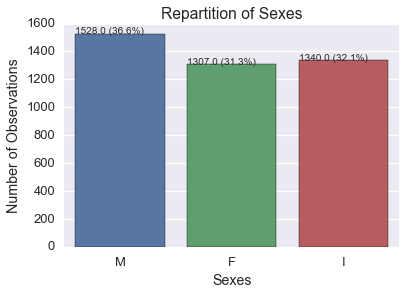

In [7]:
def plotSexes():
    total = aba['Sex'].value_counts().sum()
    g = sns.countplot(x = 'Sex', data = aba)
    g.set_title('Repartition of Sexes')
    g.set(ylabel = 'Number of Observations', xlabel = 'Sexes')
    for p in g.patches:
        g.text(p.get_x(), p.get_height(),
               '{} ({:.1f}%)'.format(p.get_height(), p.get_height() / total * 100, fontsize = 20))

plotSexes()

The repartition of sexes is relatively balanced, each one between 31% and 37%.

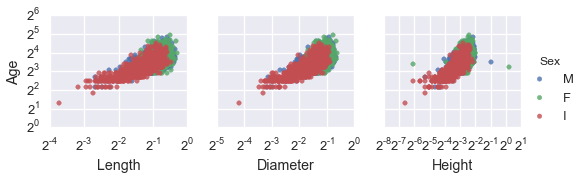

In [8]:
def pairPlotAge(mode = 'normal'):
    g = sns.PairGrid(aba, y_vars = ['Age'], x_vars = ['Length', 'Diameter', 'Height'], hue = 'Sex')
    g.map(plt.scatter, alpha = 0.8)
    if mode == 'log':
        for ax in g.axes.flat:
            ax.set_xscale('log', basex = 2)
            ax.set_yscale('log', basey = 2)
    g.add_legend()
        
    
interact(pairPlotAge, mode = ['normal', 'log']);

The above interactive widget allows to plot Length, Diameter and Height against the Age either on a normal scale or a base-2 log scale. The first observation is the log scale tends to minimize the dispersion for the high values and brings the shape closer to a 'linearish' form. The immediate conclusion is: we may have better results trying to predict the _logarithm_ of the Age instead of the Age itself.

Let's see how Length, Diameter and Height evolve with the sexes:

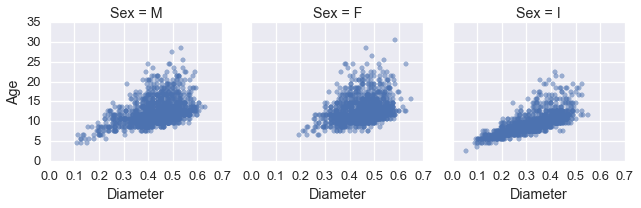

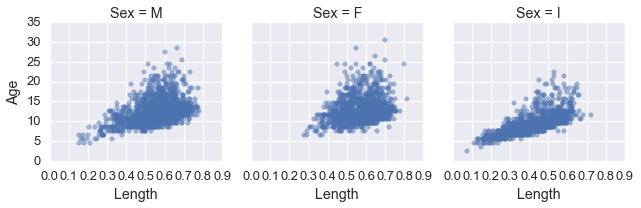

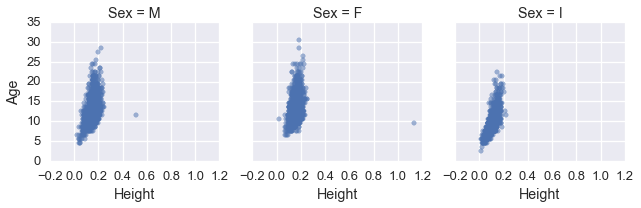

In [9]:
def facetPlotSex():
    g1 = sns.FacetGrid(aba, col = 'Sex')
    g1.map(plt.scatter, 'Diameter', 'Age', alpha = 0.5)
    g2 = sns.FacetGrid(aba, col = 'Sex')
    g2.map(plt.scatter, 'Length', 'Age', alpha = 0.5)
    g3 = sns.FacetGrid(aba, col = 'Sex')
    g3.map(plt.scatter, 'Height', 'Age', alpha = 0.5)
    
facetPlotSex()

Something catches the eye here: there is no obvious differences between males and females. However, thee differences between infants and the others is remarkable. A strict differenciation between the 3 sexes may not be the best approach for the prediction. A simpler differenciation between `infants` and `non-infants`, however, may be more efficient.

Another thing that is remarkable: 2 abalones, one male and one female, exhibit a very high height. Maybe they are suffering from some kind of abalone gigantism or we are dealing with an error inside the dataset:

In [10]:
aba[aba['Height'] > 0.4]

,Sex,Length,Diameter,Height,Weight_Whole,Weight_Shucked,Weight_Viscera,Weight_Shell,Rings,Age
1417,M,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,10,11.5
2051,F,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,8,9.5


Those 2 heights are really not realistic. We could get rid of them but the best way would be to change it with the mean of the heights for abalones of similar diameter:

In [11]:
aba.loc[1417, 'Height'] = aba.loc[(aba['Diameter'] == 0.565) & (aba['Height'] < 0.5), 'Height'].mean()
aba.loc[2051, 'Height'] = aba.loc[(aba['Diameter'] == 0.355) & (aba['Height'] < 1.0), 'Height'].mean()
aba.loc[[1417,2051], :]

,Sex,Length,Diameter,Height,Weight_Whole,Weight_Shucked,Weight_Viscera,Weight_Shell,Rings,Age
1417,M,0.705,0.565,0.196607,2.210,1.1075,0.4865,0.5120,10,11.5
2051,F,0.455,0.355,0.122643,0.594,0.3320,0.1160,0.1335,8,9.5


That's a tad better.

Now let's have a look to the weights:

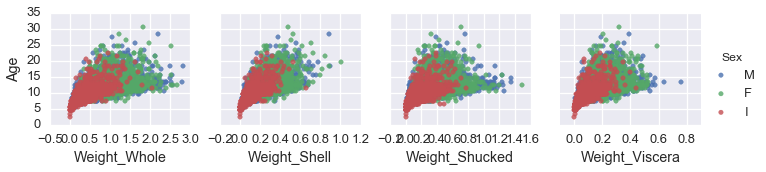

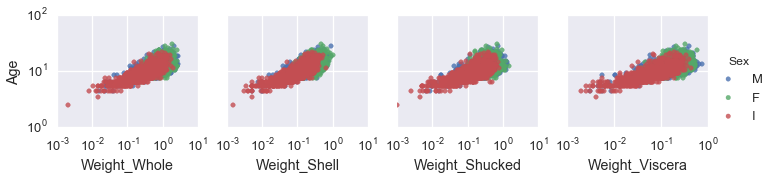

In [12]:
def pairPlotWeights():
    g1 = sns.PairGrid(aba, x_vars = ['Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera'],
                      y_vars = ['Age'], hue = 'Sex')
    g1.map(plt.scatter, alpha = 0.8)
    g1.add_legend()
    g2 = sns.PairGrid(aba, x_vars = ['Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera'],
                      y_vars = ['Age'], hue = 'Sex')
    g2.map(plt.scatter, alpha = 0.8)
    for ax in g2.axes.flat:
        ax.set_yscale('log', base = 2)
        ax.set_xscale('log', base = 2)
    g2.add_legend()

pairPlotWeights()

There is not a big difference between the different weights, we should try to select which one bears the best results for the prediction.

Another thing is the remark we made on the sexes and their link to the length, diameter and height is also valid for the weights.

Finally, let's try to have an idea of the order of the polynomial features:

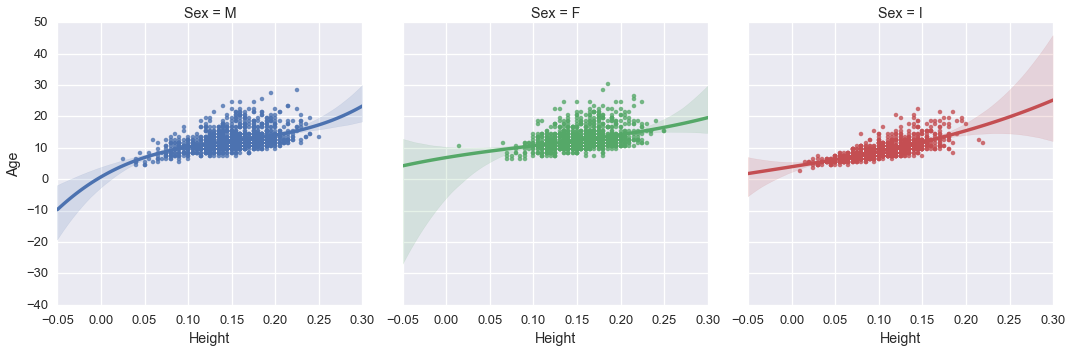

In [13]:
def interactiveLmPlot(var, order = 1):
    g = sns.lmplot(x = var, y = 'Age', data = aba, hue = 'Sex', col = 'Sex', order = order)
    
interact(interactiveLmPlot, order = (1, 10, 1),
         var = ['Length', 'Diameter', 'Height', 'Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera']);

This requires a bit of trial and error but globally, polynomial features of order 3 to 5 may be the best choice. Below, there are still too much dispersion around the fitting line. Above, the possibilities of overfitting are high as it looks like we are starting to fitting the noise.

#### Conclusion:

From data exploration we can draw the following conclusions:

* Predicting the log of age may be easier than predicting the age itself.
* For the sexes, distinguishing between infants and non-infants would be betted than distinguishing between all the 3 categories.
* Polynomial features of order 3 to 5 seem to be the best bet for better predictions

### 3- Features Selection:

Now comes the part that every data scientist has to face at some point: feature selection. Sometimes it is obvious, sometimes... Not that obvious. The first thing we can try is to have a look at the correlation between each feature. For that we will use the _Pearson Correlation Coefficient_ which is a value between -1 and +1 and accounts for the correlation between 2 variables (-1 being an absolute negative correlation, +1 being an absolute positive correlation).

This will be done through a helper function which will draw a heatmap of those coefficients against the different features. But first, we need to encode the Sex feature as following:

* 0 $\Rightarrow$ Non_infant
* 1 $\Rightarrow$ Infant

In [14]:
aba['Infant'] = aba['Sex']
aba.replace({'Infant' : {'I' : 1, 'F' : 0, 'M' : 0}}, inplace = True)
aba.loc[:, 'Infant']

0       0
1       0
2       0
3       0
4       1
5       1
6       0
7       0
8       0
9       0
       ..
4167    0
4168    0
4169    0
4170    0
4171    0
4172    0
4173    0
4174    0
4175    0
4176    0
Name: Infant, dtype: int64

Now, let's examine the correlations:

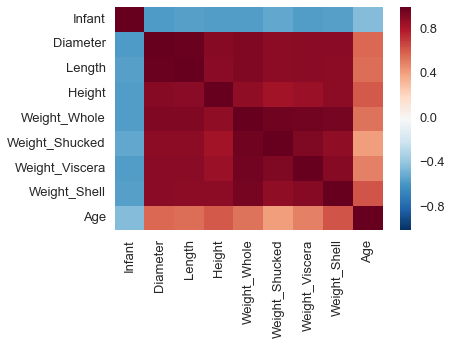

In [15]:
def corrF(data, feats):
    featsList = feats
    corrs = []
    for ft in featsList:
        col = []
        for row in featsList:
            val = pearsonr(data.loc[:, ft].values, data.loc[:, row].values)[0]
            col.append(val)
        corrs.append(col)
    sns.heatmap(corrs, xticklabels = featsList, yticklabels = featsList);
    
corrF(aba,
      feats = ['Infant', 'Diameter', 'Length', 'Height', 'Weight_Whole',
               'Weight_Shucked', 'Weight_Viscera', 'Weight_Shell', 'Age'])

Alright. So all physical measurements seem to be strongly correlated with each other. On the other hand,  the correlation with the age is lower in comparison. However, we have to point out 1 big caveat: the Pearson Correlation Coefficient only accounts for _linear_ correlation. So we have 2 possibilities here:

* Either the correlation is really weaker between the age and the other measurements...
* ... Or the correlation is somehow not linear.

On the other hand, there is a negative correlation between the physical measurement and the fact the abalone is an infant or not (which is kind of logic).

We should try first to perform a standard linear regression with all the features and removing them one by one to see which one has the biggest impact on the score:

_NOTA: all the scores will be calculated on the test set resulting from a random split of the original dataset with the
following proportions:_

* _80% \Rightarrow training set_
* _20% \Rightarrow testing set_

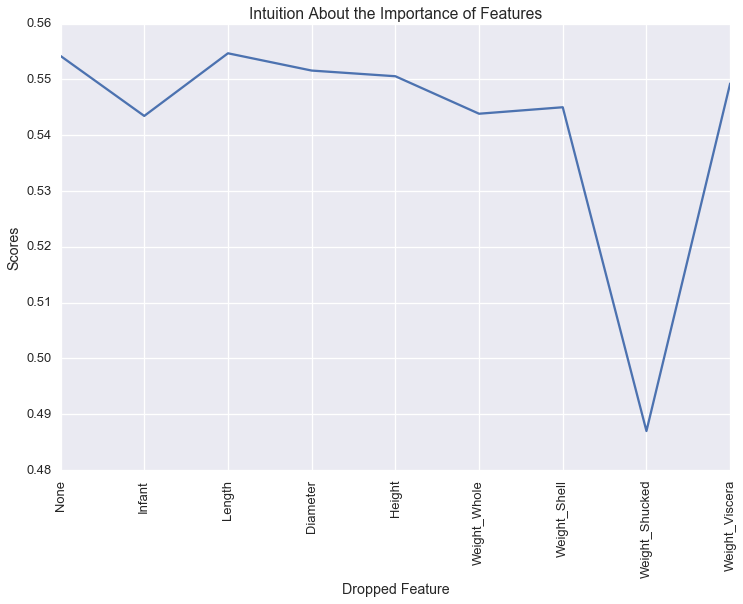

In [16]:
def fitTest(data, features, target):
    f_list = ['None'] + features
    scores = []
    for f in f_list:
        X = data.loc[:, features]
        if f != 'None':
            X.drop(f, axis = 1, inplace = True)
        y = data.loc[:, target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
        model = linear_model.LinearRegression()
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
    fig = plt.figure(figsize = (12, 8))
    plt.plot(range(len(f_list)), scores, '-')
    plt.title('Intuition About the Importance of Features')
    plt.ylabel('Scores')
    plt.xlabel('Dropped Feature')
    plt.xticks(range(len(f_list)), f_list, rotation = 90)
    
fitTest(aba, ['Infant', 'Length', 'Diameter', 'Height',
              'Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera'], 'Age')

From the above plot, we can infer the following:

* Not taking the Length in account may slightly improve the prediction.
* The new feature Infant bears a relatively strong importance.
* Both Diameter and Height are of equal importance.
* Weight_Shucked is, by far, the most important feature of all.

Let's see how those observation influence the score:

In [17]:
def compareScore(data, features, target):
    X = data.loc[:, features]
    y = data.loc[:, target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
    if len(features) == 1:
        X_train = X_train.values.reshape(-1, 1)
        X_test = X_test.values.reshape(-1, 1)
    else:
        X_train = X_train.values
        X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    print('Score = {:.4f}'.format(model.score(X_test, y_test)))

In [18]:
# All features
compareScore(aba, ['Infant', 'Length', 'Diameter', 'Height',
                   'Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera'], 'Age')
# Remove Length
compareScore(aba, ['Infant', 'Diameter', 'Height',
                   'Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera'], 'Age')
# Use Infant, Diameter, Height and Weight_Shucked
compareScore(aba, ['Infant', 'Diameter', 'Height',
                   'Weight_Shucked'], 'Age')
# Same as above plus Weight_Whole
compareScore(aba, ['Infant', 'Diameter', 'Height',
                   'Weight_Shucked', 'Weight_Whole'], 'Age')
# Same as above but use Weight_Shell instead of Weight_Whole
compareScore(aba, ['Infant', 'Diameter', 'Height',
                   'Weight_Shucked', 'Weight_Shell'], 'Age')

Score = 0.5542
Score = 0.5547
Score = 0.4491
Score = 0.5325
Score = 0.5443


So there goes our preliminary conclusion:

* Diminishing the number of features does not improve the score, except in the case of Length but not in a significant way.
* Using only Infant, Diameter, Height and Weight_Shucked is kind of disappointing as the score drops substantially.
* Adding Weight_Shell to the precedent model improves the score dramatically, but it is still below the score with all the features

Now, let's add the logarithm of the Age to the variable and see if it is easier to predict:

In [19]:
aba['LogAge'] = np.log2(aba['Age'])
aba.loc[:, ['Age', 'LogAge']].head()

,Age,LogAge
0,16.5,4.044394
1,8.5,3.087463
2,10.5,3.392317
3,11.5,3.523562
4,8.5,3.087463


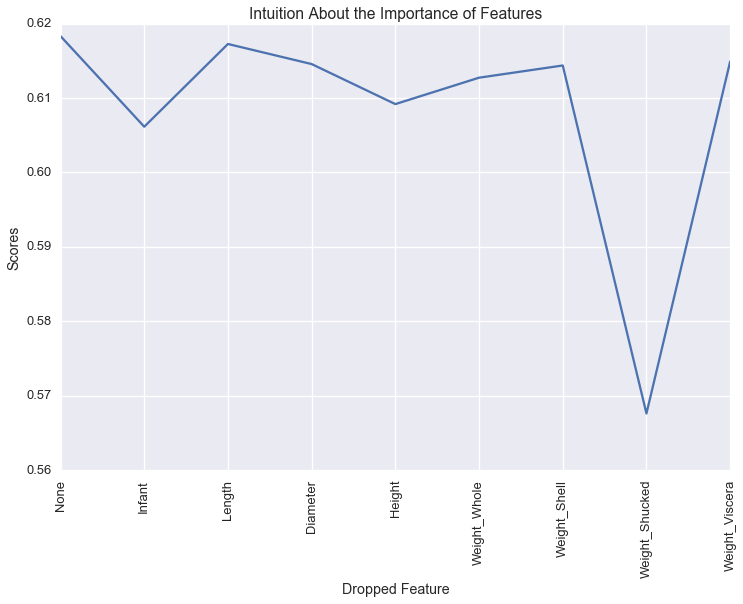

In [20]:
fitTest(aba, ['Infant', 'Length', 'Diameter', 'Height',
              'Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera'], 'LogAge')

In [21]:
# All features
compareScore(aba, ['Infant', 'Length', 'Diameter', 'Height',
                   'Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera'], 'LogAge')
# Remove Length
compareScore(aba, ['Infant', 'Diameter', 'Height',
                   'Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera'], 'LogAge')
# Use Infant, Diameter, Height and Weight_Shucked
compareScore(aba, ['Infant', 'Length', 'Diameter', 'Height',
                   'Weight_Shucked'], 'LogAge')
# Same as above plus Weight_Whole
compareScore(aba, ['Infant', 'Length', 'Diameter', 'Height',
                   'Weight_Shucked', 'Weight_Whole'], 'LogAge')
# Same as above but use Weight_Shell instead of Weight_Whole
compareScore(aba, ['Infant', 'Length', 'Diameter', 'Height',
                   'Weight_Shucked', 'Weight_Shell'], 'LogAge')

Score = 0.6183
Score = 0.6173
Score = 0.5697
Score = 0.6066
Score = 0.6126


Trying to predict the logaritm of the Age indeed bears better results. There is also a difference: Length now has a positive influence on the prediction score instead of a negative one.

However, it looks like we cannot improve the score with the current features, we need to create some new ones:

* Logarithm of Length, Diameter and Height
* Length, Diameter and Height to the power of 2
* Geometric mean of the weights
* Logarithm of the geometric mean of weights
* Geometric mean of Diameter, Length and Height
* Logarithm of the geometric mean of Diameter, Length and Height
* Euclidean norm of the weights
* Logarithm of the euclidean norm of the weights
* Euclidean norm of Diameter, Length and Height
* Logarithm of the euclidean norm of Diameter, Length and Height
* Product of Weight_Shucked with Weight_Shell

Then we will explore how those features do.

For the record:

* The _Geometric Mean_ is: $$\left( \prod_{i=1}^{n} a_i \right)^{\frac{1}{n}} = \sqrt[n]{a_1 a_2 \dots a_n}$$
* The _Arithmetic Mean_ is: $$\left( \frac{1}{n} \sum_{i=1}^{n} a_i \right) = \frac{a_1+a_2+\dots+a_n}{n}$$
* The _Euclidean Norm_ is: $$\left( \sqrt{\sum_{i=1}^{n} a_i^2} \right) = \sqrt{a_1^2 + a_2^2 + \dots + a_n^2}$$

In [22]:
aba['LogLength'] = np.log2(aba['Length'])
aba['LogDiameter'] = np.log2(aba['Diameter'])
aba['LogHeight'] = np.log2(aba['Height'])
aba['PowLength'] = aba['Length']**2
aba['PowDiameter'] = aba['Diameter']**2
aba['PowHeight'] = aba['Height']**2
aba['MeanWeights'] = np.power(aba['Weight_Whole'] +
                              aba['Weight_Shell'] +
                              aba['Weight_Shucked'] + 
                              aba['Weight_Viscera'], 1.0/4)
aba['MeanPhys'] = np.power(aba['Diameter'] +
                           aba['Length'] +
                           aba['Height'], 1.0/3)
aba['NormWeights'] = np.sqrt(aba['Weight_Whole']**2 + 
                             aba['Weight_Shell']**2 + 
                             aba['Weight_Shucked']**2 + 
                             aba['Weight_Viscera']**2)
aba['NormPhys'] = np.sqrt(aba['Diameter']**2 + 
                          aba['Length']**2 + 
                          aba['Height']**2)
aba['Weight_Shucked_Shell'] = aba['Weight_Shucked'] * aba['Weight_Shell']
aba['LogMeanWeights'] = np.log2(aba['MeanWeights'])
aba['LogMeanPhys'] = np.log2(aba['MeanPhys'])
aba['LogNormWeights'] = np.log2(aba['NormWeights'])
aba['LogNormPhys'] = np.log2(aba['NormPhys'])

In [23]:
aba.head()

,Sex,Length,Diameter,Height,Weight_Whole,Weight_Shucked,Weight_Viscera,Weight_Shell,Rings,Age,Infant,LogAge,LogLength,LogDiameter,LogHeight,PowLength,PowDiameter,PowHeight,MeanWeights,MeanPhys,NormWeights,NormPhys,Weight_Shucked_Shell,LogMeanWeights,LogMeanPhys,LogNormWeights,LogNormPhys
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5,0,4.044394,-1.136062,-1.454032,-3.395929,0.207025,0.133225,0.009025,0.997365,0.970824,0.589319,0.590995,0.033675,-0.003807,-0.042719,-0.762879,-0.758782
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0,3.087463,-1.514573,-1.915936,-3.473931,0.122500,0.070225,0.008100,0.816062,0.890013,0.260773,0.448135,0.006965,-0.293248,-0.168102,-1.939132,-1.157995
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5,0,3.392317,-0.915936,-1.251539,-2.888969,0.280900,0.176400,0.018225,1.064696,1.027566,0.766970,0.689583,0.053865,0.090442,0.039232,-0.382757,-0.536203
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5,0,3.523562,-1.184425,-1.454032,-3.000000,0.193600,0.133225,0.015625,1.000125,0.976100,0.591369,0.585192,0.033403,0.000180,-0.034899,-0.757870,-0.773017
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5,1,3.087463,-1.599462,-1.971431,-3.643856,0.108900,0.065025,0.006400,0.789746,0.872852,0.233710,0.424647,0.004922,-0.340539,-0.196191,-2.097207,-1.235664


Let's see if we can improve the score with those features:

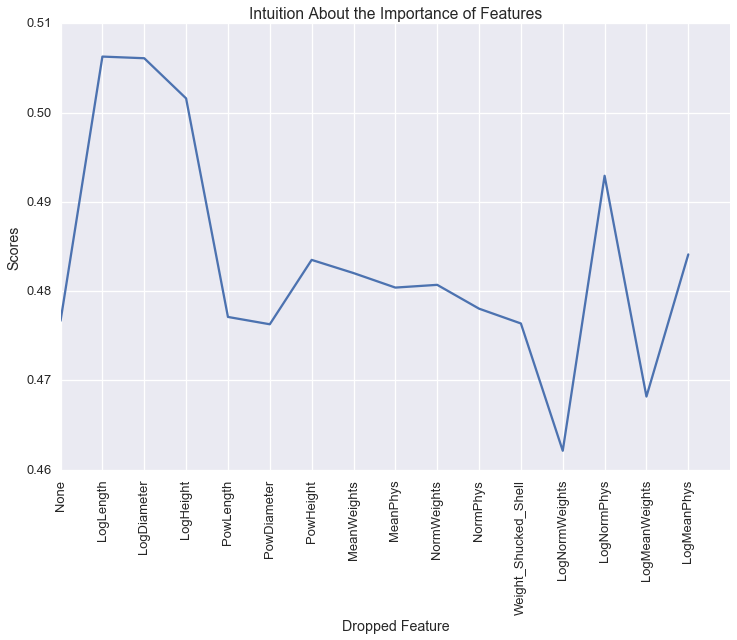

In [24]:
fitTest(aba, ['LogLength', 'LogDiameter', 'LogHeight', 'PowLength', 'PowDiameter', 'PowHeight',
              'MeanWeights', 'MeanPhys', 'NormWeights', 'NormPhys', 'Weight_Shucked_Shell',
              'LogNormWeights', 'LogNormPhys', 'LogMeanWeights', 'LogMeanPhys'], 'LogAge')

It looks like our new features do not perform that well, except maybe for the logarithm of the geometric of the weights and the logarithm of the euclidean norm of the weights...

In [25]:
# Original best score
compareScore(aba, ['Infant', 'Length', 'Diameter', 'Height',
                   'Weight_Whole', 'Weight_Shell', 'Weight_Shucked', 'Weight_Viscera'], 'LogAge')
# Adding some of the new features
compareScore(aba, ['Infant', 'Length', 'Diameter', 'Height', 'Weight_Shucked', 'Weight_Shell', 'Weight_Shucked_Shell',
                   'LogMeanWeights', 'LogMeanPhys', 'LogNormWeights', 'LogNormPhys'], 'LogAge')
# Remove Length, Diameter and Height
compareScore(aba, ['Infant', 'Weight_Shucked', 'Weight_Shell', 'Weight_Shucked_Shell',
                   'LogMeanPhys', 'LogNormPhys', 'LogNormWeights', 'LogMeanWeights'], 'LogAge')

Score = 0.6183
Score = 0.6525
Score = 0.6522


At this point, this is the best score we can come by. Removing the Diameter, the Length and the Height does not impact the score significantly.

#### Conclusion

Through feature engineering, we were able to improve the score from the original `0.55`, we are now up to `0.65`.

However, let's remind the original problem: we were trying to find the best and most simple way to predict the age of an abalone. Having to using the different weights (meaning we have to shuck it then remove and bleed the viscera), kind of defeat the purpose...

### 4- Polynomial Features:

In order to improve our model and increase the score, we can use more advanced techniques, such as Polynomial Features. However, we will pipeline them with a Ridge Regression in order to control as much as possible the possibility of overfitting.

The purpose here is to try to find the best configuration between the order of the polynomial features and the Ridge regularization coefficient (normally it'a lambda, but in `scikit-learn` it's called alpha... Go figure). This is what the following helper function will help us to achive by plotting the scores for various values of alpha and polynomial degree:

In [40]:
def polyModelTest(data, features, target, alpha, order):
    X = data.loc[:, features]
    y = data.loc[:, target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
    if len(features) == 1:
        X_train = X_train.values.reshape(-1, 1)
        X_test = X_test.values.reshape(-1, 1)
    else:
        X_train = X_train.values
        X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    fig = plt.figure(figsize = (12, 8))
    for deg in order:
        order_scores = []
        for a in alpha:
            model = make_pipeline(PolynomialFeatures(deg), Ridge(a))
            model.fit(X_train, y_train)
            order_scores.append(model.score(X_test, y_test))
        plt.plot(alpha, order_scores, '-', label = 'Order {}'.format(deg))
    plt.title('Finding Optimum Configuration for Polynomial Regression')
    plt.xlabel('Ridge Alpha')
    plt.ylabel('Scores')
    plt.legend(loc = 'lower left')

We select a range of values for alpha, from 1 to 1000. Then let's see how the scores evolve for polynomial degrees from 2 to 5:

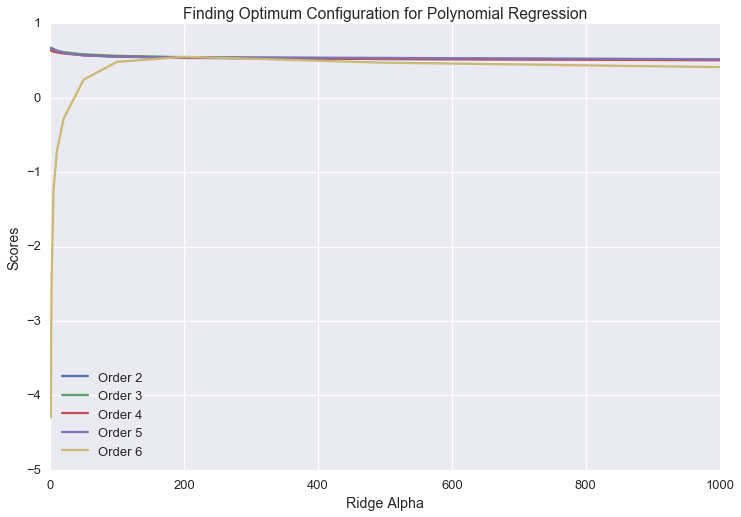

In [44]:
polyModelTest(aba,
              ['Infant', 'Weight_Shucked', 'Weight_Shell', 'Weight_Shucked_Shell',
               'LogMeanPhys', 'LogNormPhys', 'LogNormWeights', 'LogMeanWeights'], 'LogAge',
              [1,2,5,10,20,50,100,200,500,1000], [2, 3, 4, 5, 6])

First thing: there is clearly something wrong with the order 6. Let's try to zoom for alpha between 100 and 500:

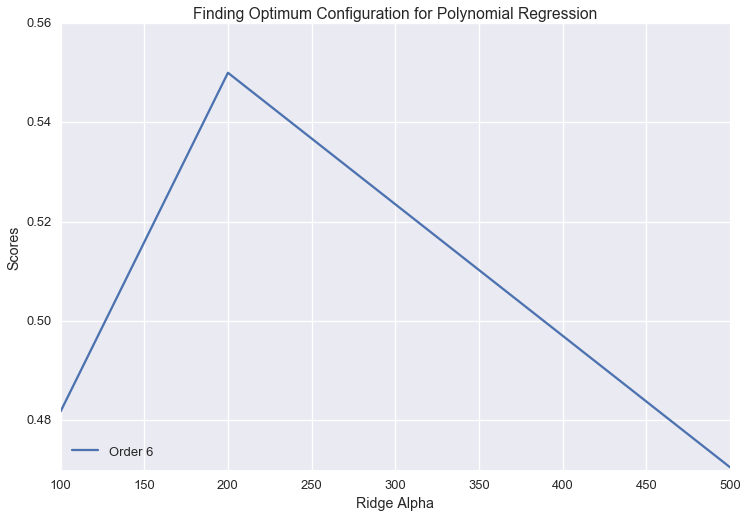

In [46]:
polyModelTest(aba,
              ['Infant', 'Weight_Shucked', 'Weight_Shell', 'Weight_Shucked_Shell',
               'LogMeanPhys', 'LogNormPhys', 'LogNormWeights', 'LogMeanWeights'], 'LogAge',
              [100,200,500], [6])

Clearly, a polynomial degree of 6 is already not working here: the maximum score we can get for alpha = 200 is substantially below the maximum score we previously got for the standard linear regression (0.55 < 0.65).

Let's focus on orders 2, 3, 4 and 5:

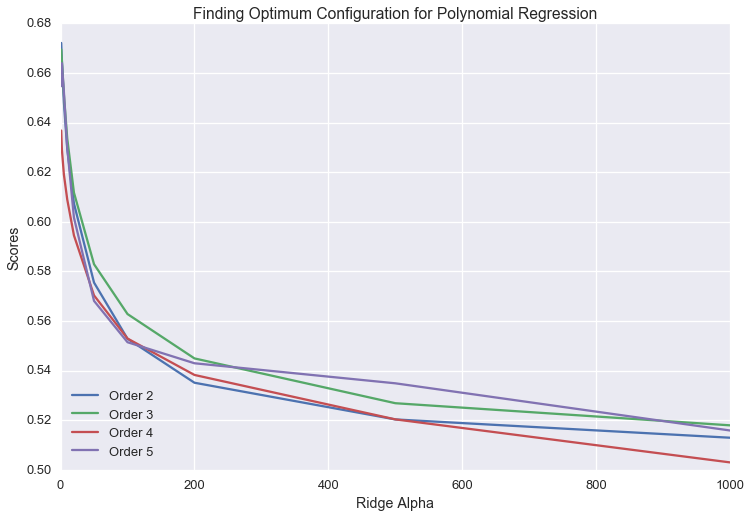

In [47]:
polyModelTest(aba,
              ['Infant', 'Weight_Shucked', 'Weight_Shell', 'Weight_Shucked_Shell',
               'LogMeanPhys', 'LogNormPhys', 'LogNormWeights', 'LogMeanWeights'], 'LogAge',
              [1,2,5,10,20,50,100,200,500,1000], [2, 3, 4, 5])

It looks like orders 2, 3 and 5 perform not too bad. Order 4, on the other hand seems to be less efficient. In every case, the best alpha we can find is 1. Scores start to drop dramatically for higher values.

Time for a final comparison:

In [58]:
def polyModelFinal(data, features, target, combined):
    X = data.loc[:, features]
    y = data.loc[:, target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
    if len(features) == 1:
        X_train = X_train.values.reshape(-1, 1)
        X_test = X_test.values.reshape(-1, 1)
    else:
        X_train = X_train.values
        X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    for deg, alpha in combined:
        model = make_pipeline(PolynomialFeatures(deg), Ridge(alpha))
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        print('Degree {:<2} (Ridge Alpha {:>4}) => Score = {:.4f}'.format(deg, alpha, score))

In [59]:
polyModelFinal(aba,
              ['Infant', 'Weight_Shucked', 'Weight_Shell', 'Weight_Shucked_Shell',
               'LogMeanPhys', 'LogNormPhys', 'LogNormWeights', 'LogMeanWeights'], 'LogAge',
              [(2, 1), (3, 1), (4, 1), (5, 1)])

Degree 2  (Ridge Alpha    1) => Score = 0.6721
Degree 3  (Ridge Alpha    1) => Score = 0.6694
Degree 4  (Ridge Alpha    1) => Score = 0.6368
Degree 5  (Ridge Alpha    1) => Score = 0.6546


### 5- Conclusion:

In the end, the best score we can come up with is ~0.67, this was made possible through:

* __Careful data cleaning:__ The original data had a few outliers that would have probably impacted our predictions if we had not removed and/or re-process them into valid values.
* __Feature Engineering:__ Feature selection is but a part of the model creation; sometimes, in order to improve the results, new features can be created by combining some of the old ones together (norms and means can also be used); this can be actually quite efficient when dealing with multicolinearity.
* __Model Tuning:__ Adjusting the parameters of the model through iterative process is a way to improve the model's efficiency as well as prevent overfitting.

However, in the end, there is no magic formula to accurately predict the age of an abalone. Simple measurements of external physical parameters is not enough and all four different weights have to be taken in account, including the weight of the shucked abalone and the weight of the bleeded viscera. The staining of the shell and the microscope are not required but it's still a somehow complicated process.